# Version 2


## Target

Add Batch-norm to increase model efficiency.

## Results

- Parameters:  7,612
- Best Train Accuracy: 99.18%
- Best Test Accuracy: 99.13%

## Analysis

- No. of model parameters got increased a bit, which was expected beacuse of Batch Normalization 
- Overall model performance got increased a bit, but we again started to see overfit and its not able to reach 99.4% accuracy 


# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import warnings
warnings.filterwarnings('ignore')

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) 
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


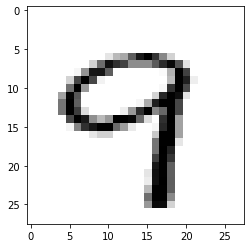

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

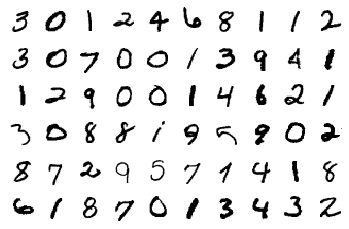

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8)
        ) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32)
        ) # output_size = 8

        # OUTPUT BLOCK
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        ) # output_size = 8
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=8)
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4           [-1, 16, 24, 24]           1,152
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
         MaxPool2d-7           [-1, 16, 12, 12]               0
            Conv2d-8            [-1, 8, 12, 12]             128
              ReLU-9            [-1, 8, 12, 12]               0
      BatchNorm2d-10            [-1, 8, 12, 12]              16
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
           Conv2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [9]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)

        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [10]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.18224652111530304 Batch_id=468 Accuracy=90.13: 100%|██████████| 469/469 [00:03<00:00, 134.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1912, Accuracy: 9729/10000 (97.29%)

EPOCH: 1


Loss=0.1375458687543869 Batch_id=468 Accuracy=97.50: 100%|██████████| 469/469 [00:03<00:00, 137.55it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1097, Accuracy: 9817/10000 (98.17%)

EPOCH: 2


Loss=0.07670027017593384 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:03<00:00, 135.51it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0750, Accuracy: 9866/10000 (98.66%)

EPOCH: 3


Loss=0.15004439651966095 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:03<00:00, 139.80it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0637, Accuracy: 9870/10000 (98.70%)

EPOCH: 4


Loss=0.07544668018817902 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:03<00:00, 141.18it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0637, Accuracy: 9876/10000 (98.76%)

EPOCH: 5


Loss=0.04316214099526405 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:03<00:00, 138.68it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0534, Accuracy: 9889/10000 (98.89%)

EPOCH: 6


Loss=0.05169856175780296 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:03<00:00, 137.09it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0515, Accuracy: 9870/10000 (98.70%)

EPOCH: 7


Loss=0.10358431190252304 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:03<00:00, 140.33it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0495, Accuracy: 9889/10000 (98.89%)

EPOCH: 8


Loss=0.02746330201625824 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:03<00:00, 138.30it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0441, Accuracy: 9896/10000 (98.96%)

EPOCH: 9


Loss=0.06195845082402229 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:03<00:00, 134.32it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0426, Accuracy: 9896/10000 (98.96%)

EPOCH: 10


Loss=0.028207024559378624 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:03<00:00, 135.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0413, Accuracy: 9900/10000 (99.00%)

EPOCH: 11


Loss=0.04774366691708565 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:03<00:00, 135.63it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0405, Accuracy: 9895/10000 (98.95%)

EPOCH: 12


Loss=0.04303964972496033 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:03<00:00, 135.44it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0365, Accuracy: 9903/10000 (99.03%)

EPOCH: 13


Loss=0.025354942306876183 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:03<00:00, 134.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0375, Accuracy: 9905/10000 (99.05%)

EPOCH: 14


Loss=0.04619552567601204 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:03<00:00, 133.71it/s] 



Test set: Average loss: 0.0357, Accuracy: 9913/10000 (99.13%)



Text(0.5, 1.0, 'Test Accuracy')

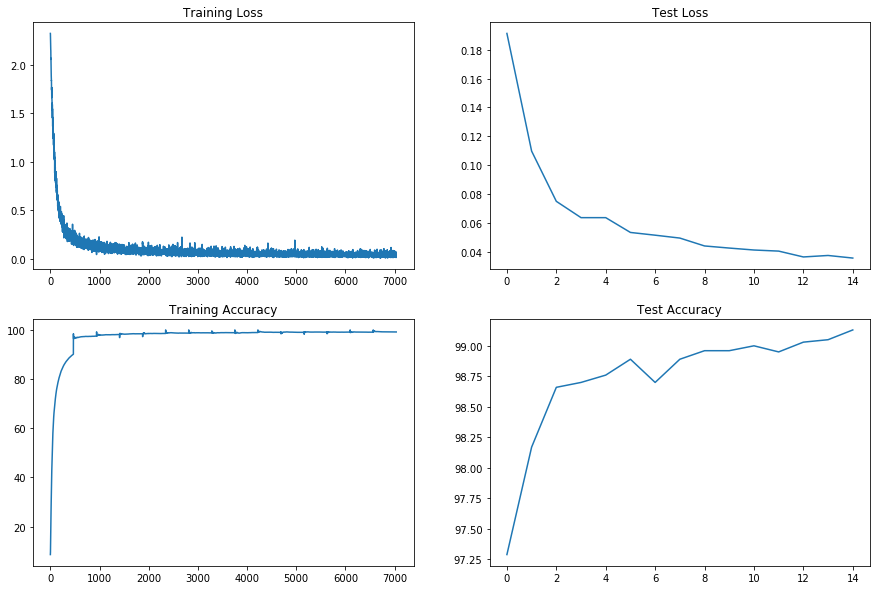

In [11]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")